# Unsupervised Learning: Clustering Lab





In [1]:
import math
import random

from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import io
from scipy.io import arff
import pandas as pd

In [2]:
# Utility functions
def load_data(url: str):
    ftp_stream = urllib.request.urlopen(url)
    data, meta = arff.loadarff(io.StringIO(ftp_stream.read().decode('utf-8')))
    data_frame = pd.DataFrame(data)
    return data_frame

def normalize_data(array):
    new_array = array.copy()
    _, num_cols = array.shape

    def normalize(value):
        return (value - cur_col_min) / float(cur_col_max - cur_col_min)

    for i in range(0, num_cols):
        cur_col = array[:, i]
        cur_col_max = np.max(cur_col)
        cur_col_min = np.min(cur_col)
        normalize_vectorized = np.vectorize(normalize)
        new_array[:, i] = normalize_vectorized(cur_col)
    return new_array

# Utility classes
class Point:
    def __init__(self, data):
        self.data = data

    def get_distance_to(self, point2):
        dist_squared_sum = 0
        for i in range(0, len(self.data)):
            dist_squared_sum += (pow(self.data[i] - point2.data[i], 2))
        return math.sqrt(dist_squared_sum)

## 1. Implement the HAC and K-means algorithms
For both algorithms:
- Use euclidean distance as the distance metric
- You only need to handle continuous features, but think about how you would handle nominal and unknown data
---
When reporting the results of each algorithm, include the following:
- The number of clusters (*k*)
- The silhouette score of the full clustering (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)

For each cluster include:
- The vectors of points representing the cluster centroid
- The number of instances tied to that centroid
---

### 1.1 HAC (Hierarchical Agglomerative Clustering)

### HAC Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from *n* to 1.  To reduce the amount of output implement a mechanism to specify for which *k* values actual output will be generated.

In [3]:
class HacCluster:
    def __init__(self, point):
        self.points = [point]

    def get_complete_link_distance(self, cluster2):
        max_distance = 0
        for i in range(0, len(self.points)):
            cluster1_point = self.points[i]
            for j in range(0, len(cluster2.points)):
                cluster2_point = cluster2.points[j]
                distance = cluster1_point.get_distance_to(cluster2_point)
                if distance > max_distance:
                    max_distance = distance
        return max_distance

    def get_single_link_distance(self, cluster2):
        min_distance = np.inf
        for i in range(0, len(self.points)):
            cluster1_point = self.points[i]
            for j in range(0, len(cluster2.points)):
                cluster2_point = cluster2.points[j]
                distance = cluster1_point.get_distance_to(cluster2_point)
                if distance < min_distance:
                    min_distance = distance
        return min_distance

    def merge(self, cluster2):
        self.points.extend(cluster2.points)

    def get_centroid(self, num_decimals=None):
        avg_point = [0] * len(self.points[0].data)
        for point in self.points:
            for j in range(0, len(self.points[0].data)):
                avg_point[j] += point.data[j]
        for i in range(0, len(avg_point)):
            avg_point[i] /= len(self.points)
            if num_decimals is not None:
                avg_point[i] = round(avg_point[i], num_decimals)
        return avg_point


class HACClustering(BaseEstimator, ClusterMixin):

    def __init__(self, k=3, link_type='single'):  ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.clusters = []
        self.data = []

    def fit(self, data):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.initialize_clusters(data)
        while len(self.clusters) > self.k:
            cluster_index1, cluster_index2 = self.find_nearest_clusters()
            self.merge_clusters(cluster_index1, cluster_index2)
        return self

    def print_clusters(self, num_decimals=None):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}".format(self.k))
        print("Silhouette score: {:.4f}\n".format(self.get_silhouette_score()))
        for cluster in self.clusters:
            print(cluster.get_centroid(num_decimals=num_decimals))
            print(len(cluster.points))

    def initialize_clusters(self, data):
        self.data = data
        self.clusters = []
        for row in data:
            point = Point(row)
            cluster = HacCluster(point)
            self.clusters.append(cluster)

    def find_nearest_clusters(self):
        min_distance = np.inf
        cluster_indices = (-1, -1)
        for cluster1_index in range(0, len(self.clusters)):
            for cluster2_index in range(cluster1_index + 1, len(self.clusters)):
                cluster1 = self.clusters[cluster1_index]
                cluster2 = self.clusters[cluster2_index]
                distance_between = self.get_distance(cluster1, cluster2)
                if distance_between < min_distance:
                    min_distance = distance_between
                    cluster_indices = (cluster1_index, cluster2_index)
        return cluster_indices

    def get_distance(self, cluster1, cluster2):
        if self.link_type == 'single':
            return cluster1.get_single_link_distance(cluster2)
        else:
            return cluster1.get_complete_link_distance(cluster2)

    def merge_clusters(self, cluster1_index, cluster2_index):
        cluster1 = self.clusters[cluster1_index]
        cluster2 = self.clusters[cluster2_index]
        cluster1.merge(cluster2)
        del self.clusters[cluster2_index]

    def get_silhouette_score(self):
        classified_data = []
        classifications = []
        for i, cluster in enumerate(self.clusters):
            for point in cluster.points:
                classified_data.append(point.data)
            cluster_classifications = [i] * len(cluster.points)
            classifications.extend(cluster_classifications)
        return silhouette_score(X=classified_data, labels=classifications)

### 1.1.1 (15%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points are commented out.

- Include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit normalization, else you will not get the same answers as us.
- Report results for *k* = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [4]:
# Debug Here
def run_single_debug():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"))
    normalized_data = normalize_data(raw_data)
    hac_clustering = HACClustering(k=5, link_type="single")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)


def run_complete_debug():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"))
    normalized_data = normalize_data(raw_data)
    hac_clustering = HACClustering(k=5, link_type="complete")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)

print("Single debug")
run_single_debug()
print()
print()
print("Complete debug")
run_complete_debug()

Single debug
Num clusters: 5
Silhouette score: 0.3453

[0.599, 0.5923, 0.4915, 0.2826, 0.2682, 0.2921, 0.2316, 0.3849]
195
[0.9189, 0.9438, 0.7105, 0.7016, 0.759, 0.7222, 0.4472, 0.8824]
1
[1.0, 0.9831, 0.8026, 0.8343, 0.6575, 0.7825, 0.9221, 0.8824]
2
[1.0, 0.9888, 0.7895, 1.0, 1.0, 0.8915, 0.7186, 0.5882]
1
[0.9189, 0.9888, 0.8684, 0.719, 0.5797, 0.7512, 0.6432, 0.9412]
1
Complete debug
Num clusters: 5
Silhouette score: 0.3095

[0.6544, 0.649, 0.5256, 0.2879, 0.2815, 0.3057, 0.2288, 0.3911]
71
[0.3661, 0.3505, 0.271, 0.1008, 0.1024, 0.1058, 0.0836, 0.2116]
67
[0.7622, 0.7658, 0.6759, 0.4265, 0.4016, 0.4536, 0.3376, 0.5217]
38
[0.8818, 0.8904, 0.7582, 0.614, 0.5433, 0.5317, 0.561, 0.7794]
16
[0.9471, 0.934, 0.8158, 0.7457, 0.6434, 0.7944, 0.6457, 0.625]
8


Discussion

### 1.1.2 (15%) Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

#### Complete Link

In [5]:
# Load evaluation data
# Train on evaluation data using complete link
# Print clusters
def run_hac_complete_eval():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"))

    def decode(value):
        if type(value) == bytes:
            return value.decode()
        return value
    decode_vectorized = np.vectorize(decode)
    decoded_data = decode_vectorized(raw_data)
    normalized_data = normalize_data(decoded_data)
    hac_clustering = HACClustering(k=5, link_type="complete")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)

run_hac_complete_eval()

Num clusters: 5
Silhouette score: 0.2930

[0.3636, 0.4107, 0.5609, 0.3857, 0.3937, 0.2808, 0.3155, 0.0]
49
[0.3471, 0.3622, 0.7897, 0.279, 0.441, 0.8568, 0.2234, 0.0]
3
[0.1656, 0.2226, 0.3509, 0.2328, 0.152, 0.3424, 0.1918, 0.0]
18
[0.7918, 0.8268, 0.606, 0.7669, 0.7787, 0.4634, 0.7877, 1.0]
49
[0.5326, 0.6002, 0.4536, 0.5531, 0.5144, 0.5401, 0.6266, 1.0]
21


#### Single Link

In [6]:
# Load evaluation data
# Train on evaluation data using single link
# Print clusters
def run_hac_single_eval():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"))

    def decode(value):
        if type(value) == bytes:
            return value.decode()
        return value
    decode_vectorized = np.vectorize(decode)
    decoded_data = decode_vectorized(raw_data)
    normalized_data = normalize_data(decoded_data)
    hac_clustering = HACClustering(k=5, link_type="single")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)

run_hac_single_eval()

Num clusters: 5
Silhouette score: 0.3971

[0.3159, 0.3648, 0.5145, 0.349, 0.3338, 0.3077, 0.2868, 0.0]
67
[0.2774, 0.2597, 1.0, 0.1224, 0.4505, 0.7549, 0.129, 0.0]
1
[0.3065, 0.3333, 0.6979, 0.2792, 0.3787, 1.0, 0.2373, 0.0]
1
[0.0884, 0.1818, 0.0, 0.145, 0.1538, 0.1245, 0.0, 0.0]
1
[0.714, 0.7588, 0.5603, 0.7028, 0.6994, 0.4864, 0.7393, 1.0]
70


Discussion

### 1.2 K-means

### Code requirements 
- Ability to choose *k* and specify the *k* initial centroids
- Ability to handle distance ties--when a node or cluster has the same distance to another cluster, which should be rare, choose the earliest cluster in your list

In [7]:
class KMeansCluster:
    def __init__(self, point):
        self.points = []
        self.centroid = point
        self.previous_centroid = None

    def add_point(self, point):
        self.points.append(point)

    def clear_points(self):
        self.points = []

    def get_centroid(self, num_decimals=None):
        avg_point = [0] * len(self.points[0].data)
        for point in self.points:
            for j in range(0, len(self.points[0].data)):
                avg_point[j] += point.data[j]
        for i in range(0, len(avg_point)):
            avg_point[i] /= len(self.points)
            if num_decimals is not None:
                avg_point[i] = round(avg_point[i], num_decimals)
        return avg_point

    def set_centroid(self):
        centroid = self.get_centroid()
        self.previous_centroid = Point(self.centroid.data)
        self.centroid = Point(centroid)
        return centroid

    def check_changed(self):
        if self.previous_centroid is None:
            return True

        for i in range(0, len(self.centroid.data)):
            if self.centroid.data[i] != self.previous_centroid.data[i]:
                return True
        return False

class KMEANSClustering(BaseEstimator, ClusterMixin):

    def __init__(self, k=3, debug=False):  ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.clusters = []
        self.data = []
        self.raw_data = []

    def fit(self, X):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.initialize_points(X)
        self.initialize_clusters()
        converged = False
        while not converged:
            self.group_cluster_points()
            converged = self.check_converged()
            if not converged:
                self.reset_cluster_points()
        return self

    def initialize_points(self, X):
        self.data = []
        for row in X:
            self.data.append(Point(row))

    def initialize_clusters(self):
        self.clusters = []
        if self.debug:
            for i in range(0, self.k):
                self.clusters.append(KMeansCluster(self.data[i]))
        else:
            selection_data = self.data.copy()
            for i in range(0, self.k):
                point_index = random.randint(0, len(selection_data) - 1)
                self.clusters.append(KMeansCluster(selection_data[point_index]))
                selection_data = np.delete(selection_data, point_index, 0)

    def reset_cluster_points(self):
        for cluster in self.clusters:
            cluster.set_centroid()
            cluster.clear_points()

    def group_cluster_points(self):
        for point_index, data_point in enumerate(self.data):
            min_distance = np.inf
            min_cluster_index = -1
            for i, cluster in enumerate(self.clusters):
                distance_to_centroid = data_point.get_distance_to(cluster.centroid)
                if distance_to_centroid < min_distance:
                    min_distance = distance_to_centroid
                    min_cluster_index = i
            self.clusters[min_cluster_index].add_point(data_point)

    def check_converged(self):
        for cluster in self.clusters:
            cluster_changed = cluster.check_changed()
            if cluster_changed:
                return False
        return True

    def print_clusters(self, num_decimals=None):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.k))
        print("Silhouette score: {:.4f}\n\n".format(self.get_silhouette_score()))
        for cluster in self.clusters:
            print(cluster.get_centroid(num_decimals=num_decimals))
            print(len(cluster.points))

    def get_silhouette_score(self):
        classified_data = []
        classifications = []
        for i, cluster in enumerate(self.clusters):
            for point in cluster.points:
                classified_data.append(point.data)
            cluster_classifications = [i] * len(cluster.points)
            classifications.extend(cluster_classifications)
        return silhouette_score(X=classified_data, labels=classifications)

### 1.2.1 (10%) K-Means Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)

- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit nomralization, else you will not get the same answers as us.
- Use *k* = 5
- Use the first *k* instances in the training set as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

---
Solution in file:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [8]:
# Load debug data
# Train on debug data
# Print clusters
def run_kmeans_debug():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"))
    normalized_data = normalize_data(raw_data)
    kmeans_clustering = KMEANSClustering(k=5, debug=True)
    kmeans_clustering.fit(normalized_data)
    kmeans_clustering.print_clusters(num_decimals=4)

run_kmeans_debug()

Num clusters: 5

Silhouette score: 0.3845


[0.7325, 0.7327, 0.627, 0.3817, 0.3633, 0.4045, 0.3046, 0.4839]
75
[0.3704, 0.3519, 0.2686, 0.0926, 0.0935, 0.094, 0.0792, 0.218]
34
[0.9035, 0.905, 0.7774, 0.6579, 0.5767, 0.6193, 0.5893, 0.7279]
24
[0.5692, 0.5628, 0.4376, 0.211, 0.2113, 0.2248, 0.1659, 0.317]
54
[0.1296, 0.1037, 0.1053, 0.0177, 0.0211, 0.0272, 0.0135, 0.0724]
13


### 1.2.2 (15%) K-Means Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

In [9]:
# Load evaluation data
# Train on evaluation data
# Print clusters
def run_kmeans_evaluation():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"))

    def decode(value):
        if type(value) == bytes:
            return value.decode()
        return value
    decode_vectorized = np.vectorize(decode)
    decoded_data = decode_vectorized(raw_data)
    normalized_data = normalize_data(decoded_data)
    kmeans_clustering = KMEANSClustering(k=5, debug=True)
    kmeans_clustering.fit(normalized_data)
    kmeans_clustering.print_clusters(num_decimals=4)

run_kmeans_evaluation()

Num clusters: 5

Silhouette score: 0.2769


[0.5349, 0.6013, 0.4617, 0.5541, 0.5232, 0.5544, 0.6248, 1.0]
22
[0.3684, 0.4338, 0.4356, 0.4388, 0.3573, 0.2988, 0.3673, 0.0]
31
[0.3658, 0.3854, 0.7563, 0.3093, 0.4659, 0.3691, 0.2413, 0.0]
20
[0.1634, 0.2137, 0.3968, 0.2178, 0.1555, 0.3078, 0.1775, 0.0]
19
[0.7961, 0.831, 0.6054, 0.7709, 0.7802, 0.4553, 0.7919, 1.0]
48


## 2. Iris Clustering with Both Alogrithms
For both algorithms: 
- Don't include the output label as one of the input features
- Normalize the data
- Show your results for clusterings with *k* = 2-7.  
- Graph the silhouette score for each *k* and discuss your results (i.e. what kind of clusters are being made).
- Load this Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

### 2.1 (10%) Iris Clustering with HAC

- Use single-link and complete link clustering algorithms
---

Single-link HAC Clustering with k = 2
Num clusters: 2
Silhouette score: 0.6864

[5.006, 3.418, 1.464, 0.244]
50
[6.262, 2.872, 4.906, 1.676]
100


Single-link HAC Clustering with k = 3
Num clusters: 3
Silhouette score: 0.5118

[5.006, 3.418, 1.464, 0.244]
50
[6.2306, 2.8531, 4.8724, 1.6673]
98
[7.8, 3.8, 6.55, 2.1]
2


Single-link HAC Clustering with k = 4
Num clusters: 4
Silhouette score: 0.2818

[5.006, 3.418, 1.464, 0.244]
50
[6.2443, 2.8567, 4.8763, 1.667]
97
[4.9, 2.5, 4.5, 1.7]
1
[7.8, 3.8, 6.55, 2.1]
2


Single-link HAC Clustering with k = 5
Num clusters: 5
Silhouette score: 0.2835

[5.006, 3.418, 1.464, 0.244]
50
[6.2978, 2.8806, 4.9452, 1.6946]
93
[5.0, 2.3, 3.275, 1.025]
4
[4.9, 2.5, 4.5, 1.7]
1
[7.8, 3.8, 6.55, 2.1]
2


Single-link HAC Clustering with k = 6
Num clusters: 6
Silhouette score: 0.2211

[5.006, 3.418, 1.464, 0.244]
50
[6.288, 2.8728, 4.9326, 1.6859]
92
[5.0, 2.3, 3.275, 1.025]
4
[4.9, 2.5, 4.5, 1.7]
1
[7.2, 3.6, 6.1, 2.5]
1
[7.8, 3.8, 6.55, 2.1]
2


Single-link H

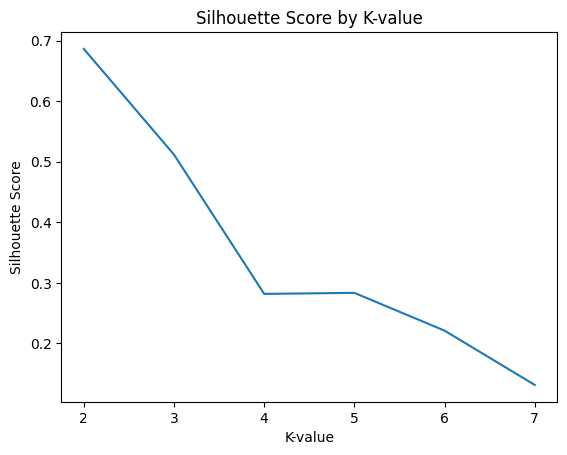

In [10]:
# Iris Clustering using single-link
def run_hac_single_iris():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = raw_data[:,:-1]
    k_array = [2, 3, 4, 5, 6, 7]
    silhouette_scores = []
    for i in k_array:
        print(f"Single-link HAC Clustering with k = {i}")
        hac_clustering = HACClustering(k=i, link_type="single")
        hac_clustering.fit(data)
        hac_clustering.print_clusters(num_decimals=4)
        silhouette_scores.append(hac_clustering.get_silhouette_score())
        print()
        print()
    plt.plot(k_array, silhouette_scores)
    plt.title("Silhouette Score by K-value")
    plt.xlabel("K-value")
    plt.ylabel("Silhouette Score")
    plt.show()

run_hac_single_iris()

Complete-link HAC Clustering with k = 2
Num clusters: 2
Silhouette score: 0.5161

[5.1949, 3.1372, 2.3603, 0.5974]
78
[6.5458, 2.9639, 5.2736, 1.85]
72


Complete-link HAC Clustering with k = 3
Num clusters: 3
Silhouette score: 0.5134

[5.006, 3.418, 1.464, 0.244]
50
[6.5458, 2.9639, 5.2736, 1.85]
72
[5.5321, 2.6357, 3.9607, 1.2286]
28


Complete-link HAC Clustering with k = 4
Num clusters: 4
Silhouette score: 0.4996

[5.006, 3.418, 1.464, 0.244]
50
[6.36, 2.9317, 5.0683, 1.81]
60
[5.5321, 2.6357, 3.9607, 1.2286]
28
[7.475, 3.125, 6.3, 2.05]
12


Complete-link HAC Clustering with k = 5
Num clusters: 5
Silhouette score: 0.3500

[4.8103, 3.2, 1.3966, 0.2]
29
[5.2762, 3.719, 1.5571, 0.3048]
21
[6.36, 2.9317, 5.0683, 1.81]
60
[5.5321, 2.6357, 3.9607, 1.2286]
28
[7.475, 3.125, 6.3, 2.05]
12


Complete-link HAC Clustering with k = 6
Num clusters: 6
Silhouette score: 0.3421

[4.8103, 3.2, 1.3966, 0.2]
29
[5.2762, 3.719, 1.5571, 0.3048]
21
[6.2395, 2.8421, 4.7974, 1.6053]
38
[5.5321, 2.6357, 3

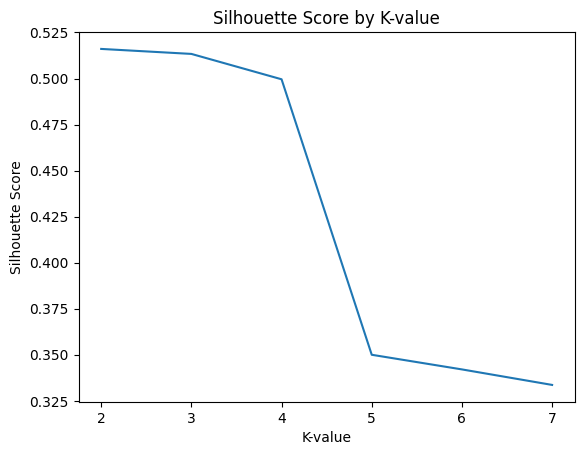

In [11]:
# Iris Clustering using complete-link
def run_hac_complete_iris():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = raw_data[:,:-1]
    k_array = [2, 3, 4, 5, 6, 7]
    silhouette_scores = []
    for i in k_array:
        print(f"Complete-link HAC Clustering with k = {i}")
        hac_clustering = HACClustering(k=i, link_type="complete")
        hac_clustering.fit(data)
        hac_clustering.print_clusters(num_decimals=4)
        silhouette_scores.append(hac_clustering.get_silhouette_score())
        print()
        print()
    plt.plot(k_array, silhouette_scores)
    plt.title("Silhouette Score by K-value")
    plt.xlabel("K-value")
    plt.ylabel("Silhouette Score")
    plt.show()

run_hac_complete_iris()

Discuss your results including the differences between single-link and complete-link

### 2.2 (10%) Iris Clustering with K-means

KMeans Clustering with k = 2
Num clusters: 2

Silhouette score: 0.6808


[6.301, 2.8866, 4.9588, 1.6959]
97
[5.0057, 3.3604, 1.5623, 0.2887]
53


KMeans Clustering with k = 3
Num clusters: 3

Silhouette score: 0.5167


[5.2167, 3.64, 1.4733, 0.28]
30
[4.7417, 2.9542, 1.7542, 0.3292]
24
[6.3146, 2.8958, 4.974, 1.7031]
96


KMeans Clustering with k = 4
Num clusters: 4

Silhouette score: 0.4185


[5.2556, 3.6704, 1.5037, 0.2889]
27
[5.9016, 2.7484, 4.3935, 1.4339]
62
[6.85, 3.0737, 5.7421, 2.0711]
38
[4.713, 3.1217, 1.4174, 0.1913]
23


KMeans Clustering with k = 5
Num clusters: 5

Silhouette score: 0.4885


[6.5292, 3.0583, 5.5083, 2.1625]
24
[7.475, 3.125, 6.3, 2.05]
12
[6.2077, 2.8538, 4.7462, 1.5641]
39
[5.006, 3.418, 1.464, 0.244]
50
[5.508, 2.6, 3.908, 1.204]
25


KMeans Clustering with k = 6
Num clusters: 6

Silhouette score: 0.3489


[6.2366, 2.8585, 4.8073, 1.622]
41
[5.49, 3.92, 1.46, 0.26]
10
[4.69, 3.085, 1.385, 0.19]
20
[5.5296, 2.6222, 3.9407, 1.2185]
27
[6.9125, 3.1, 5.8469

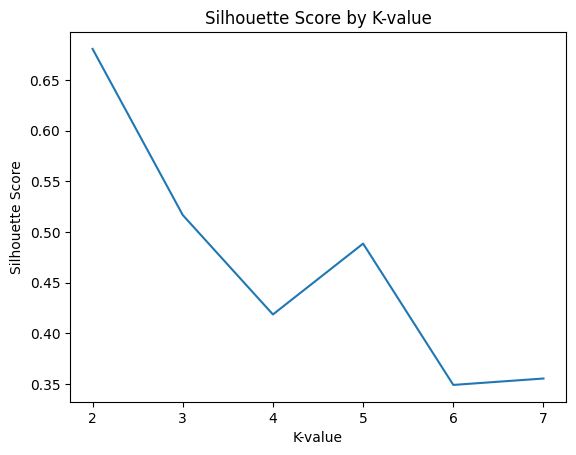

In [12]:
# Iris Clustering with K-means
def run_kmeans_iris():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = raw_data[:, :-1]
    k_array = [2, 3, 4, 5, 6, 7]
    silhouette_scores = []
    for i in k_array:
        print(f"KMeans Clustering with k = {i}")
        kmeans_clustering = KMEANSClustering(k=i)
        kmeans_clustering.fit(data)
        kmeans_clustering.print_clusters(num_decimals=4)
        silhouette_scores.append(kmeans_clustering.get_silhouette_score())
        print()
        print()
    plt.plot(k_array, silhouette_scores)
    plt.title("Silhouette Score by K-value")
    plt.xlabel("K-value")
    plt.ylabel("Silhouette Score")
    plt.show()

run_kmeans_iris()

Discuss your results

### 2.3 (5%) K-means Initial Centroids Experiment

- Run K-means 5 times with *k*=4, each time with different initial random centroids and discuss any variations in the results.
- If you ever end up with any empty clusters in K-means, re-run with different initial centroids.

In [13]:
#K-means 5 times
def run_iris_centroid_experiment():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = raw_data[:, :-1]
    for i in range(0, 5):
        print(f"KMeans Clustering with k = 5, iteration {i}")
        kmeans_clustering = KMEANSClustering(k=4)
        kmeans_clustering.fit(data)
        kmeans_clustering.print_clusters(num_decimals=4)
        print()
        print()

run_iris_centroid_experiment()

KMeans Clustering with k = 5, iteration 0
Num clusters: 4

Silhouette score: 0.4951


[6.2936, 2.9, 4.9511, 1.7298]
47
[7.087, 3.1261, 6.013, 2.1435]
23
[5.58, 2.6333, 3.9867, 1.2333]
30
[5.006, 3.418, 1.464, 0.244]
50


KMeans Clustering with k = 5, iteration 1
Num clusters: 4

Silhouette score: 0.4124


[5.3706, 3.8, 1.5176, 0.2765]
17
[5.8836, 2.741, 4.3885, 1.4344]
61
[4.8182, 3.2212, 1.4364, 0.2273]
33
[6.8538, 3.0769, 5.7154, 2.0538]
39


KMeans Clustering with k = 5, iteration 2
Num clusters: 4

Silhouette score: 0.4972


[5.006, 3.418, 1.464, 0.244]
50
[6.2366, 2.8585, 4.8073, 1.622]
41
[6.9125, 3.1, 5.8469, 2.1312]
32
[5.5296, 2.6222, 3.9407, 1.2185]
27


KMeans Clustering with k = 5, iteration 3
Num clusters: 4

Silhouette score: 0.4963


[5.006, 3.418, 1.464, 0.244]
50
[5.5321, 2.6357, 3.9607, 1.2286]
28
[7.0148, 3.0963, 5.9185, 2.1556]
27
[6.2644, 2.8844, 4.8867, 1.6667]
45


KMeans Clustering with k = 5, iteration 4
Num clusters: 4

Silhouette score: 0.4974


[6.2628, 2.86

Discuss any variations in the results

## 3. Scikit-Learn Comparison

### 3.1 (10%) Run the SK versions of HAC (just complete link) and K-means on Iris data set above

- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [14]:
# Load sklearn
def run_sklearn_iris_hac():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = raw_data[:, :-1]

    for i in range(2, 8):
        print(f"Complete link - n-clusters={i}")
        sklearn_hac = AgglomerativeClustering(n_clusters=i, linkage="complete")
        labels = sklearn_hac.fit_predict(data)
        print(silhouette_score(data, labels))
    print()

    print("Ward link - n-clusters=2")
    sklearn_hac = AgglomerativeClustering(n_clusters=2, linkage="ward")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("Ward link - n-clusters=3")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, linkage="ward")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("Average link - n-clusters=3")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("L1 affinitiy, n-clusters=3, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, affinity='l1', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("L2 affinitiy, n-clusters=3, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, affinity='l2', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))


def run_sklearn_iris_kmeans():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = raw_data[:, :-1]

    print("KMeans")
    for i in range(2,8):
        print(f"n-clusters={i}")
        sklearn_kmeans = KMeans(n_clusters=i, n_init=1, init="random")
        labels = sklearn_kmeans.fit_predict(data)
        print(silhouette_score(data, labels))
    print()

    print("n-clusters=3, number of different trial seeds=10, kmeans++ centroid initialization")
    sklearn_kmeans = KMeans(n_clusters=3)
    labels = sklearn_kmeans.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

run_sklearn_iris_hac()
run_sklearn_iris_kmeans()

Complete link - n-clusters=2
0.5160600757054667
Complete link - n-clusters=3
0.5133502348448076
Complete link - n-clusters=4
0.4995741149430846
Complete link - n-clusters=5
0.34999771139358965
Complete link - n-clusters=6
0.34205174735616767
Complete link - n-clusters=7
0.33362901571416487

Ward link - n-clusters=2
0.6863930543445408

Ward link - n-clusters=3
0.5540972908150553

Average link - n-clusters=3
0.5539343898551252

L1 affinitiy, n-clusters=3, average link
0.5533104830639192

L2 affinitiy, n-clusters=3, average link
0.5539343898551252
KMeans
n-clusters=2
0.6808136202936816
n-clusters=3
0.5525919445499757
n-clusters=4
0.49511999553021513
n-clusters=5
0.3744919666758033
n-clusters=6
0.4816973410185572
n-clusters=7
0.31346815318400334

n-clusters=3, number of different trial seeds=10, kmeans++ centroid initialization
0.5525919445499757



*Discuss Results and Comparison with your versions of the algorithms. Discuss effects of different hyperparameters*

### 3.2 (10%) Run the SK version of HAC (just complete link) and K-means on a dataset of your choice 
- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [15]:
# Load sklearn
def run_sklearn_texts_hac():
    data = np.array(pd.read_csv("https://raw.githubusercontent.com/maclaurin36/CS472-clustering/master/AllBooks_baseline_DTM_Unlabelled.csv"))
    for i in range(5, 12):
        print(f"Complete link - n-clusters={i}")
        sklearn_hac = AgglomerativeClustering(n_clusters=i, linkage="complete")
        labels = sklearn_hac.fit_predict(data)
        print(silhouette_score(data, labels))
    print()

    print("Ward link - n-clusters=8")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, linkage="ward")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("Average link - n-clusters=8")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("L1 affinitiy, n-clusters=8, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, affinity='l1', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

    print("L2 affinitiy, n-clusters=8, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, affinity='l2', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))


def run_sklearn_texts_kmeans():
    data = np.array(pd.read_csv(
        "https://raw.githubusercontent.com/maclaurin36/CS472-clustering/master/AllBooks_baseline_DTM_Unlabelled.csv"))
    print("KMeans")
    for i in range(5,12):
        print(f"n-clusters={i}")
        sklearn_kmeans = KMeans(n_clusters=i, n_init=1, init="random")
        labels = sklearn_kmeans.fit_predict(data)
        print(silhouette_score(data, labels))
    print()

    print("n-clusters=8, number of different trial seeds=10, kmeans++ centroid initialization")
    sklearn_kmeans = KMeans(n_clusters=8)
    labels = sklearn_kmeans.fit_predict(data)
    print(silhouette_score(data, labels))
    print()

run_sklearn_texts_hac()
run_sklearn_texts_kmeans()

Complete link - n-clusters=5
0.6247438549348783
Complete link - n-clusters=6
0.4449368831094327
Complete link - n-clusters=7
0.44628789916054346
Complete link - n-clusters=8
0.4471359561570107
Complete link - n-clusters=9
0.43912066839416647
Complete link - n-clusters=10
0.44033018715539624
Complete link - n-clusters=11
0.44229934759367395

Ward link - n-clusters=8
0.3907018791143226

Average link - n-clusters=8
0.5529648044356759

L1 affinitiy, n-clusters=8, average link
0.4348161888430102

L2 affinitiy, n-clusters=8, average link
0.5529648044356759
KMeans
n-clusters=5
0.35965204216643054
n-clusters=6
0.21106149290562415
n-clusters=7
-0.07420660950177287
n-clusters=8
-0.0025777992526888407
n-clusters=9
0.0810485814029367
n-clusters=10
0.13460771604477584
n-clusters=11
0.03330071811575288

n-clusters=8, number of different trial seeds=10, kmeans++ centroid initialization
0.3812050648087297



*Discussion*

## 4. (Optional 5% extra credit) Write your own code for silhouette
If you do this option implement your code for silhouette above in your main implementation and use it for your experiments. Make it clear that the silhouette results come from your code. You may/should compare with the SK version to debug/verify your results.

*Discussion*